In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sbibm.visualisation import fig_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import numpy as np
import seaborn as sns
from typing import Any, Dict, List, Optional

from paper.utils import fig_metric_mpl, extract_diagnostic, fig_diagnostic

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torch
prior1 = torch.distributions.Normal(0, 1)
prior2 = torch.distributions.Uniform(-2.5, 2.5, validate_args=False)

posterior1 = torch.distributions.Normal(0.3, 0.3)
posterior2 = torch.distributions.Normal(1.0, 0.3)

In [5]:
posterior_samples1 = posterior1.sample((1_000_000,))
posterior_samples2 = posterior2.sample((1_000_000,))

posterior_logprobs1 = posterior1.log_prob(posterior_samples1)
posterior_logprobs2 = posterior2.log_prob(posterior_samples2)

log_prob_thr1 = torch.quantile(posterior_logprobs1, 0.0001)
log_prob_thr2 = torch.quantile(posterior_logprobs2, 0.0001)

In [6]:
def sir(posterior, prior, log_prob_thr):

    batch_size = 100000
    vals1 = []
    for sir_oversample in [16, 64, 256, 1024]:

        posterior_samples = posterior.sample((batch_size * sir_oversample,))
        posterior_log_probs = posterior.log_prob(posterior_samples)
        prior_log_probs = prior.log_prob(posterior_samples)
        truncated_prior_log_probs = prior_log_probs
        truncated_prior_log_probs[posterior_log_probs < log_prob_thr] = -float("inf")
        ratio = truncated_prior_log_probs - posterior_log_probs
        reshaped_ratio = torch.reshape(ratio, (batch_size, sir_oversample))
        cat_dist = torch.distributions.Categorical(logits=reshaped_ratio)
        categorical_samples = cat_dist.sample((1,))[0, :]
        reshaped_posterior_samples = torch.reshape(
            posterior_samples, (batch_size, sir_oversample, -1)
        )
        selected_posterior_samples = reshaped_posterior_samples[
            torch.arange(batch_size), categorical_samples
        ]
        hist_vals, bins = np.histogram(selected_posterior_samples.numpy()[:100000, 0], bins=100, range=(-3, 3), density=True)
        vals1.append(hist_vals)
        
    return vals1, bins

In [7]:
def rejection(posterior, prior, log_prob_thr):
    batch_size = 100000
    candidates = prior.sample((int(batch_size*10),)).reshape(int(batch_size*10), -1)
    posterior_log_probs = posterior.log_prob(candidates)
    are_accepted_by_classifier = posterior_log_probs > log_prob_thr
    samples1 = candidates[are_accepted_by_classifier.bool()]
    hist_vals_rejecetion1, bins = np.histogram(samples1.numpy()[:100000], bins=100, range=(-3, 3), density=True)
    return hist_vals_rejecetion1, bins

In [8]:
vals11, bins1 = sir(posterior1, prior1, log_prob_thr1)
vals21, bins1 = sir(posterior2, prior1, log_prob_thr2)

In [9]:
hist_vals_rejecetion11, bins1 = rejection(posterior1, prior1, log_prob_thr1)
hist_vals_rejecetion21, bins1 = rejection(posterior2, prior1, log_prob_thr2)

In [20]:
vals12, bins2 = sir(posterior1, prior2, log_prob_thr1)
vals22, bins2 = sir(posterior2, prior2, log_prob_thr2)

hist_vals_rejecetion12, bins2 = rejection(posterior1, prior2, log_prob_thr1)
hist_vals_rejecetion22, bins2 = rejection(posterior2, prior2, log_prob_thr2)

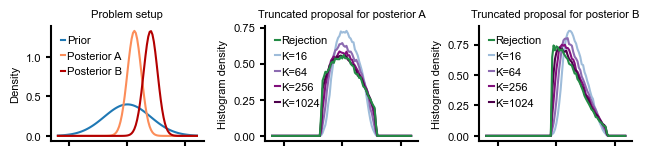

In [39]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(7.5, 1.5))

    prior_probs = prior1.log_prob(torch.as_tensor(bins1)).exp().numpy()
    ax[0].plot(bins1, prior_probs, c="#1f78b4")

    posterior_probs1 = posterior1.log_prob(torch.as_tensor(bins1)).exp().numpy()
    ax[0].plot(bins1, posterior_probs1, c="#fc8d59")
    
    posterior_probs2 = posterior2.log_prob(torch.as_tensor(bins1)).exp().numpy()
    ax[0].plot(bins1, posterior_probs2, c="#b30000")
    ax[0].legend(["Prior", "Posterior A", "Posterior B"], loc="upper left", handlelength=0.4, handletextpad=0.15)
    ax[0].set_ylabel("Density")
    ax[0].set_title("Problem setup")
    ax[0].set_xticklabels([])

    sir_colors = ["#9ebcda", "#8c6bb1", "#810f7c", "#4d004b"]
    
    ax[1].plot(bins1[:-1], hist_vals_rejecetion11, c="#238b45", zorder=1000)
    for ii in range(4):
        ax[1].plot(bins1[:-1], vals11[ii], c=sir_colors[ii])
    
    ax[1].legend(["Rejection", "K=16", "K=64", "K=256", "K=1024"], loc="upper left", handlelength=0.4, handletextpad=0.15)
    ax[1].set_title("Truncated proposal for posterior A")
    ax[1].set_ylabel("Histogram density")
    ax[1].set_xticklabels([])
    
    ax[2].plot(bins1[:-1], hist_vals_rejecetion21, c="#238b45", zorder=1000)
    for ii in range(4):
        ax[2].plot(bins1[:-1], vals21[ii], c=sir_colors[ii])

    ax[2].legend(["Rejection", "K=16", "K=64", "K=256", "K=1024"], loc="upper left", handlelength=0.4, handletextpad=0.15)
    ax[2].set_title("Truncated proposal for posterior B")
    ax[2].set_ylabel("Histogram density")
    ax[2].set_xticklabels([])
    plt.subplots_adjust(wspace=0.4)
    plt.savefig("../svg/panel_sir_is_uniform_a.svg")

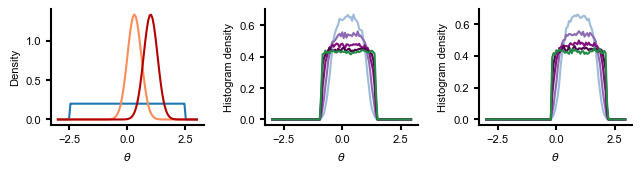

In [36]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(7.5, 1.5))

    prior_probs = prior2.log_prob(torch.as_tensor(bins2)).exp().numpy()
    ax[0].plot(bins2, prior_probs, c="#1f78b4")

    posterior_probs1 = posterior1.log_prob(torch.as_tensor(bins2)).exp().numpy()
    ax[0].plot(bins2, posterior_probs1, c="#fc8d59")
    
    posterior_probs2 = posterior2.log_prob(torch.as_tensor(bins2)).exp().numpy()
    ax[0].plot(bins2, posterior_probs2, c="#b30000")
    # ax[0].legend(["Prior", "Posterior A", "Posterior B"], loc="upper left", handlelength=0.5, handletextpad=0.2)
    ax[0].set_ylabel("Density")
    ax[0].set_xlabel(r"$\theta$")

    sir_colors = ["#9ebcda", "#8c6bb1", "#810f7c", "#4d004b"]
    
    ax[1].plot(bins2[:-1], hist_vals_rejecetion12, c="#238b45", zorder=1000)
    for ii in range(4):
        ax[1].plot(bins2[:-1], vals12[ii], c=sir_colors[ii])
    
    # ax[1].legend(["Rejection", "K=16", "K=64", "K=256", "K=1024"], loc="upper left", handlelength=0.5, handletextpad=0.2)
    ax[1].set_ylabel("Histogram density")
    ax[1].set_xlabel(r"$\theta$")
    
    ax[2].plot(bins2[:-1], hist_vals_rejecetion22, c="#238b45", zorder=1000)
    for ii in range(4):
        ax[2].plot(bins2[:-1], vals22[ii], c=sir_colors[ii])

    # ax[2].legend(["Rejection", "K=16", "K=64", "K=256", "K=1024"], loc="upper left", handlelength=0.5, handletextpad=0.2)
    ax[2].set_ylabel("Histogram density")
    ax[2].set_xlabel(r"$\theta$")
    plt.subplots_adjust(wspace=0.4)
    plt.savefig("../svg/panel_sir_is_uniform_b.svg")

In [37]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [49]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("15.7cm", "7.6cm",

    Panel(
          SVG("../svg/panel_sir_is_uniform_a.svg").scale(svg_scale).move(0, 0),
        Text("a", 5, 16, **kwargs_text),
    ).move(-5, -5),
    Panel(
          SVG("../svg/panel_sir_is_uniform_b.svg").scale(svg_scale).move(0, 0),
        Text("b", 5, 16, **kwargs_text),
    ).move(-5, 140),
)

f.save("../fig/fig4_appendix_sir_uniform.svg")
svg('../fig/fig4_appendix_sir_uniform.svg')